In [11]:
import pennylane as qml
import pennylane.numpy as np
import jax.numpy as jnp
from scipy.special import legendre
import jax
from jax import lax
import optax
from functools import partial

from tqdm.notebook import tqdm


from time import time
import pickle

import matplotlib.pyplot as plt


import os, sys, argparse

parent = os.path.abspath('../src')
sys.path.insert(1, parent)

from perceptron import Perceptron


# Set to float64 precision and remove jax CPU/GPU warning
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_platform_name", "cpu")

In [2]:

def get_loss_function(perceptron, ts, H_obj, dev):

    @jax.jit
    @jax.vmap
    @qml.qnode(dev, interface="jax")
    def loss(param_vector):

        param_list = perceptron.vector_to_hamiltonian_parameters(param_vector)

        qml.evolve(perceptron.H)(param_list, ts)

        return qml.expval(H_obj)

    return loss

In [12]:

# setting up the problem
perceptron_qubits = 5
pulse_basis = 5
ts = jnp.array([0.0, 1.0])

dev = qml.device("default.qubit.jax", wires = perceptron_qubits)


perceptron = Perceptron(perceptron_qubits, pulse_basis, basis='gaussian', pulse_width=0.5e-2)

H =  perceptron.H

H_obj, H_obj_spectrum = perceptron.get_1d_ising_hamiltonian(0.1)

e_ground_state_exact = H_obj_spectrum[0]

print(f'Ising Model Hamiltonian:\nH = {H_obj}')
print(f'Exact ground state energy: {e_ground_state_exact}')

Ising Model Hamiltonian:
H =   (0.1) [X0]
+ (0.1) [X1]
+ (0.1) [X2]
+ (0.1) [X3]
+ (0.1) [X4]
+ (1.0) [Z0 Z1]
+ (1.0) [Z1 Z2]
+ (1.0) [Z2 Z3]
+ (1.0) [Z3 Z4]
Exact ground state energy: -4.017524005494907


Once we have all the necessary perceptron functions working, we will start by defining some parameters for the genetic algorithm

In [19]:
POPULATION_SIZE = 50
SURVIVOR_THRESHOLD = int(POPULATION_SIZE/2)

OFFSPRING_SIZE = POPULATION_SIZE-SURVIVOR_THRESHOLD
CHROMOSOME_SIZE = len(perceptron.get_random_parameter_vector(0))

CROSSOVER_RATE = 0.4
MUTATION_RATE = 0.4


MUTATION_STD = 0.01

In [20]:
V = qml.matrix(qml.evolve(H_obj, 1))

@jax.jit
@jax.vmap
def fitness(param_vector):

    param_list = perceptron.vector_to_hamiltonian_parameters(param_vector)

    U = qml.matrix(qml.evolve(perceptron.H)(param_list, 1))

    return qml.math.frobenius_inner_product(jnp.conjugate(U-V),U-V).real


In [21]:
def generate_random_seed():
    
    random_seed = int(time() * 1000)  # time in milliseconds

    return random_seed


generate_random_seed()

1704261252152

In [22]:
def get_random_population(seed = 0):

    key = jax.random.PRNGKey(seed)

    upper_bound = 1e11  # arbitray higher bound, but shouldn't matter too much
    random_integers = jax.random.randint(key, (POPULATION_SIZE,), minval=0, maxval=int(upper_bound))

    population = jnp.array([perceptron.get_random_parameter_vector(jj) for jj in random_integers])
    
    return population


@jax.jit
def selection(population_array):

    fitness_array = fitness(population_array)

    sorted_indices = jnp.argsort(fitness_array)

    sorted_population_array = population_array[sorted_indices]
    sorted_fitness_array = fitness_array[sorted_indices]

    survivors_array = sorted_population_array[:SURVIVOR_THRESHOLD]
    survivors_fitness = sorted_fitness_array[:SURVIVOR_THRESHOLD]

    return survivors_array, survivors_fitness
    

def crossover(parent1, parent2, rate=0.2):

    # chromosome_size = len(parent1)
    CONTINUOUS_CROSSOVER_SIZE = int(CHROMOSOME_SIZE*rate)
    # CONTINUOUS_CROSSOVER_SIZE = jnp.floor(CHROMOSOME_SIZE * rate).astype(int)


    seed = generate_random_seed()
    key = jax.random.PRNGKey(seed)
    crossover_point = jax.random.randint(key, shape=(1,), minval=0, maxval=CHROMOSOME_SIZE)[0]

    child1 = jnp.concatenate([parent1[:crossover_point], parent2[crossover_point:]])
    child2 = jnp.concatenate([parent2[:crossover_point], parent1[crossover_point:]])

    # # Dynamic slicing using lax.dynamic_slice
    # child1_first_part = lax.dynamic_slice(parent1, (0,), (crossover_point,))
    # child1_second_part = lax.dynamic_slice(parent2, (crossover_point,), (chromosome_size - crossover_point,))
    # child1 = jnp.concatenate([child1_first_part, child1_second_part])

    # child2_first_part = lax.dynamic_slice(parent2, (0,), (crossover_point,))
    # child2_second_part = lax.dynamic_slice(parent1, (crossover_point,), (chromosome_size - crossover_point,))
    # child2 = jnp.concatenate([child2_first_part, child2_second_part])


    continuous_crossover_genes = jax.random.choice(key, CHROMOSOME_SIZE, shape=(CONTINUOUS_CROSSOVER_SIZE,), replace=False)

    # as suggested on the quantum control paper
    random_betas = jax.random.uniform(key, continuous_crossover_genes.shape)

    # vectorized operations
    child1 = child1.at[continuous_crossover_genes].set(random_betas[continuous_crossover_genes]*parent1[continuous_crossover_genes] + (1-random_betas[continuous_crossover_genes])*parent2[continuous_crossover_genes])
    child2 = child2.at[continuous_crossover_genes].set(random_betas[continuous_crossover_genes]*parent2[continuous_crossover_genes] + (1-random_betas[continuous_crossover_genes])*parent1[continuous_crossover_genes])


    # this loop is essentially doing the same thing, but the vectorized code is marginally more efficient

    # for ii in crossover_points[1:]:
        
    #     child1 = child1.at[ii].set(random_betas[ii]*parent1[ii] + (1-random_betas[ii])*parent2[ii])
    #     child2 = child2.at[ii].set(random_betas[ii]*parent2[ii] + (1-random_betas[ii])*parent1[ii])


    return child1, child2


def mutation(individual, rate = 0.2):

    MUTATION_SIZE = int(CHROMOSOME_SIZE*rate)

    seed = generate_random_seed()
    key = jax.random.PRNGKey(seed)
    mutation_points = jax.random.choice(key, CHROMOSOME_SIZE, shape=(MUTATION_SIZE,), replace=False)

    mutations = jax.random.normal(key, (MUTATION_SIZE,))*MUTATION_STD

    mutated_individual = jnp.copy(individual)

    mutated_individual = mutated_individual.at[mutation_points].set(mutations + individual[mutation_points])

    return mutated_individual


def mating(survivors_array, survivors_fitness, crossover_rate = 0.2, mutation_rate = 0.2):

    shifted_fitness_array = -(survivors_fitness - survivors_fitness[-1]) + 0.001 # this is a small bias to give the least fit individual a non-zero mating probability
    mating_probabilities = shifted_fitness_array/jnp.sum(shifted_fitness_array)

    seed = generate_random_seed()
    key = jax.random.PRNGKey(seed)

    # in theory this allows for cloning, but let's see if this works. I might come back and try to fix this later
    parents = jax.random.choice(key, survivors_array, shape=(OFFSPRING_SIZE,), replace=True, p=mating_probabilities)

    first_parents = parents[:int(OFFSPRING_SIZE/2)]
    second_parents = parents[int(OFFSPRING_SIZE/2):]


    offspring = []

    for parent1, parent2 in zip(first_parents, second_parents):

        child1, child2 = crossover(parent1, parent2, rate = crossover_rate)


        offspring.append(mutation(child1, rate=mutation_rate))
        offspring.append(mutation(child2, rate=mutation_rate))


    return jnp.array(offspring)

And we thus proceed with the optimization loop

In [29]:
best_fitness_values = []
best_fitness_chromosomes = []
average_fitness_values = []


population_array = get_random_population()
for gen in tqdm(range(1000)):

    fitness_array = fitness(population_array)

    min_idx = jnp.argmin(fitness_array)

    min_fitness_value = fitness_array[min_idx]
    main_fitness_chromosome = population_array[min_idx]
    average_fitness = jnp.average(fitness_array)

    # if gen % 5 == 0:

    #     print(f'Generation {gen+1}')
    #     print(f'Best Fitness: {min_fitness_value}')
    #     print(f'Average Fitness: {average_fitness}')

    best_fitness_values.append(min_fitness_value)
    best_fitness_chromosomes.append(main_fitness_chromosome)
    average_fitness_values.append(average_fitness)

    survivors_array, survivors_fitness = selection(population_array)

    offspring_array = mating(survivors_array, survivors_fitness, CROSSOVER_RATE, MUTATION_RATE)

    population_array = jnp.concatenate([survivors_array, offspring_array])
    


  0%|          | 0/1000 [00:00<?, ?it/s]

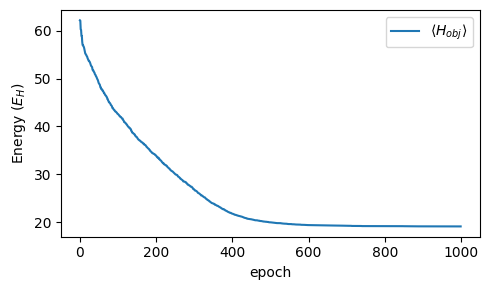

In [30]:
fig, ax = plt.subplots(nrows=1, figsize=(5, 3), sharex=True)

y = best_fitness_values
ax.plot(y, label="$\\langle H_{{obj}}\\rangle$")
# ax.plot(y, ".:", label="$\\langle H_{{obj}}\\rangle$")
# ax.fill_between([0, len(y)], [1e-3] * 2, 3e-4, alpha=0.2, label="chem acc.")
# ax.set_yscale("log")
ax.set_ylabel("Energy ($E_H$)")
ax.set_xlabel("epoch")
ax.legend()

plt.tight_layout()
plt.show()

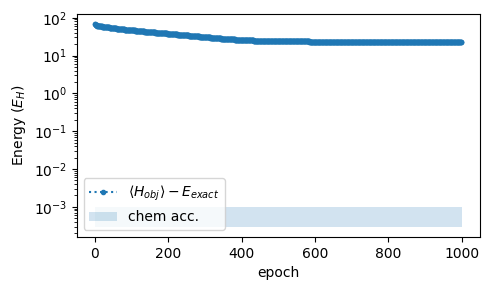

In [31]:
fig, ax = plt.subplots(nrows=1, figsize=(5, 3), sharex=True)

y = best_fitness_values - e_ground_state_exact
ax.plot(y, ".:", label="$\\langle H_{{obj}}\\rangle - E_{exact}$")
ax.fill_between([0, len(y)], [1e-3] * 2, 3e-4, alpha=0.2, label="chem acc.")
ax.set_yscale("log")
ax.set_ylabel("Energy ($E_H$)")
ax.set_xlabel("epoch")
ax.legend()

plt.tight_layout()
plt.show()

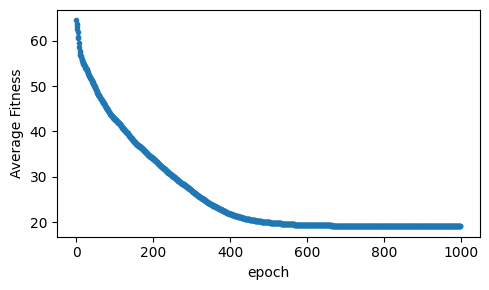

In [32]:
fig, ax = plt.subplots(nrows=1, figsize=(5, 3), sharex=True)

y = average_fitness_values

ax.plot(y, ".:")
# ax.fill_between([0, len(y)], [1e-3] * 2, 3e-4, alpha=0.2, label="chem acc.")
# ax.set_yscale("log")
ax.set_ylabel("Average Fitness")
ax.set_xlabel("epoch")
# ax.legend()

plt.tight_layout()
plt.show()

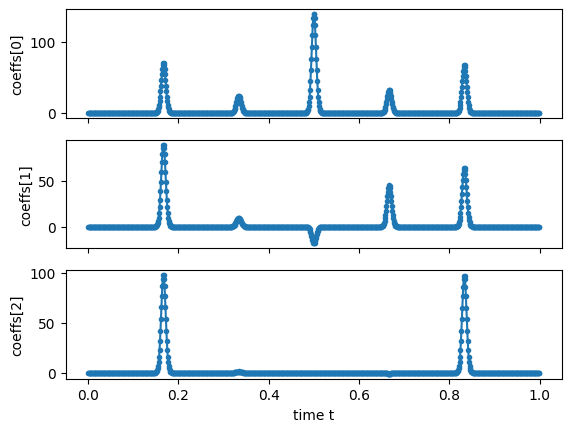

In [24]:
ts = jnp.linspace(0.0, 1, 1000)[:-1]

param_list = perceptron.vector_to_hamiltonian_parameters(best_fitness_chromosomes[-1])

fig, axs = plt.subplots(nrows=perceptron_qubits, sharex=True)
for i in range(perceptron_qubits):
    ax = axs[i]
    ax.plot(ts, perceptron.control_fields[i](param_list[i+perceptron_qubits-1], ts), ".-")
    ax.set_ylabel(f"coeffs[{i}]")
ax.set_xlabel("time t")
plt.show()